In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [48]:
data = pd.read_csv('Product Demand.csv' ,index_col=['Date'],parse_dates=['Date'])

In [49]:
data.head()

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2012-07-27,993,10,28,100
2012-01-19,979,10,28,500
2012-02-03,979,10,28,500
2012-02-09,979,10,28,500
2012-03-02,979,10,28,500


In [50]:
#Check the data types.
data.dtypes

Product_Code        int64
Warehouse           int64
Product_Category    int64
Order_Demand        int64
dtype: object

In [51]:
data.shape

(1048575, 4)

In [52]:
#Drop na's.
#Since the number of missing values are about 1%,taking an 'executive decision' of removing them.  
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)
data.sort_values('Date')[10:20] #Some of the values have () in them.

,Product_Code,Warehouse,Product_Category,Order_Demand
Date,,,,
2011-10-31,642,50,19,3
2011-11-04,202,70,7,-100
2011-11-04,202,70,7,-400
2011-11-18,2143,20,9,-25
2011-11-18,131,20,21,-12
2011-11-18,288,20,21,-50
2011-11-18,980,70,28,4000
2011-11-18,2138,20,9,-49
2011-11-18,2137,20,9,-25


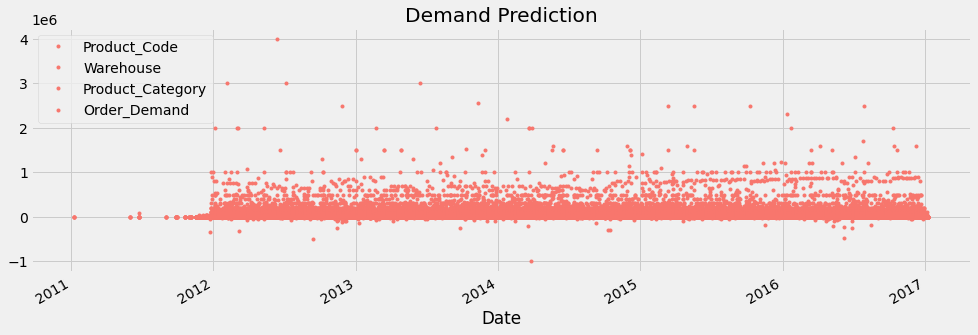

In [54]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='.', figsize=(15,5), color=color_pal[0], title='Demand Prediction')

In [55]:
split_date = '01-Jan-2015'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [60]:
data = data.apply(pd.to_numeric)

In [61]:
#Check the data types.
data.dtypes

Product_Code        int64
Warehouse           int64
Product_Category    int64
Order_Demand        int64
dtype: object

In [63]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [64]:
X_train, y_train = create_features(data_train, label='Order_Demand')
X_test, y_test = create_features(data_test, label='Order_Demand')

In [65]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

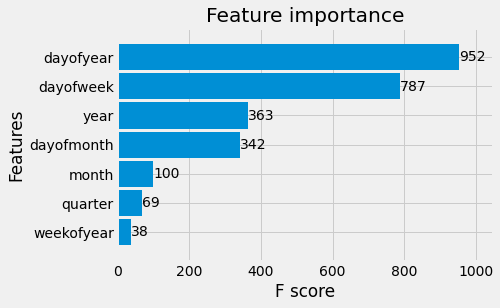

In [66]:
_ = plot_importance(reg, height=0.9)

In [69]:
data_test['Product_Code'] = reg.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

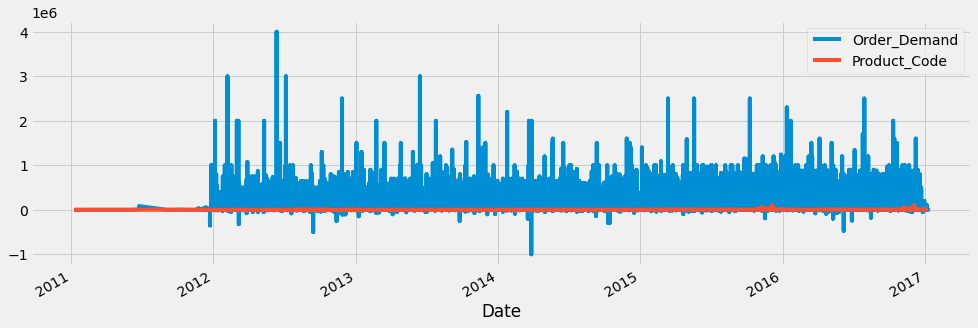

In [70]:
_ = data_all[['Order_Demand','Product_Code']].plot(figsize=(15, 5))

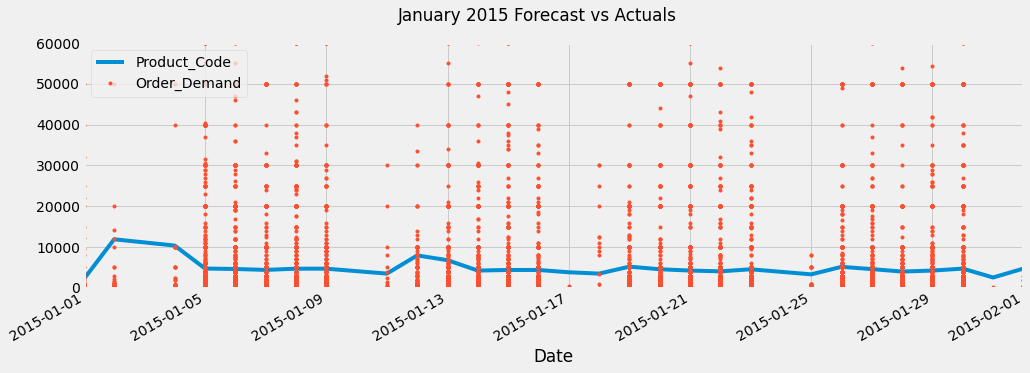

In [71]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Product_Code','Order_Demand']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

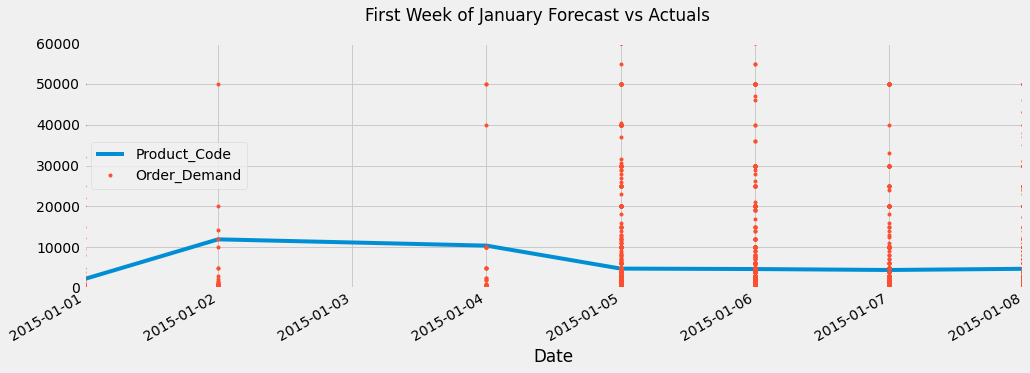

In [72]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Product_Code','Order_Demand']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

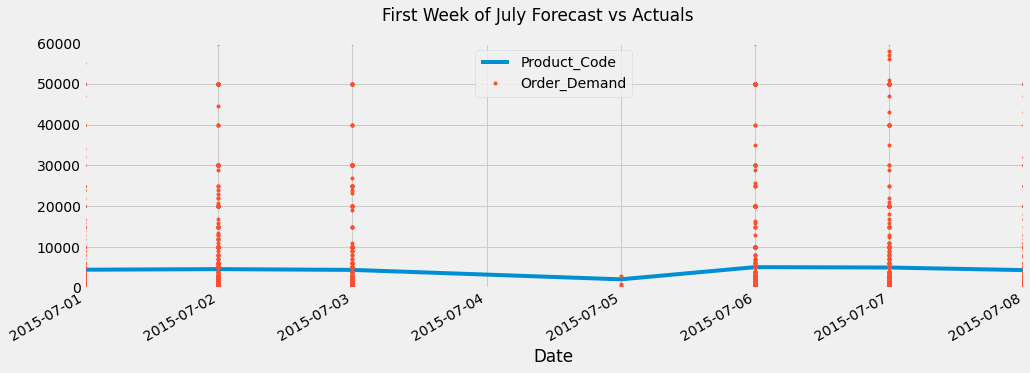

In [73]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Product_Code','Order_Demand']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [75]:
mean_squared_error(y_true=data_test['Order_Demand'],
                   y_pred=data_test['Product_Code'])

919813972.6360465

In [76]:
mean_absolute_error(y_true=data_test['Order_Demand'],
                   y_pred=data_test['Product_Code'])

7362.415231733271

In [77]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [79]:
mean_absolute_percentage_error(y_true=data_test['Order_Demand'],
                   y_pred=data_test['Product_Code'])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


inf

In [80]:
data_test['error'] = data_test['Order_Demand'] - data_test['Product_Code']
data_test['abs_error'] = data_test['error'].apply(np.abs)
error_by_day = data_test.groupby(['year','month','dayofmonth']) \
    .mean()[['Order_Demand','Product_Code','error','abs_error']]

In [81]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

Order_Demand   Product_Code         error  \
year month dayofmonth                                              
2015 12    6           32291.500000  106281.078125 -73989.578125   
     11    8           11420.100000   56479.218750 -45059.118750   
           29          13777.707692   56645.910156 -42868.202464   
           1            4067.142857   34845.746094 -30778.603237   
2016 11    13          17372.258065   46658.945312 -29286.687248   
2017 1     2              70.000000   11295.313477 -11225.313477   
2015 10    25           7278.950000   16708.378906  -9429.428906   
     5     3             165.285714    7940.712891  -7775.427176   
     12    30           4231.927928   11431.843750  -7199.915822   
     3     20           4088.539952   11054.889648  -6966.349697   

                           abs_error  
year month dayofmonth                 
2015 12    6           117149.514706  
     11    8            53763.275000  
           29           66971.405228  
           1            35432.478516  
2016 11    13           57889.335938  
2017 1     2            11225.313477  
2015 10    25           18861.365755  
     5     3             7775.427176  
     12    30           11549.626408  
     3     20           10922.649289

In [82]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

Order_Demand   Product_Code          error  \
year month dayofmonth                                                
2015 9     6           283333.333333    1716.785889  281616.547445   
2016 12    4           111166.500000  107158.765625    4007.734375   
     3     20          136666.666667    3328.884521  133337.782145   
     11    6            93844.400000   56479.218750   37365.181250   
2015 12    6            32291.500000  106281.078125  -73989.578125   
     10    10          116666.666667    4082.931396  112583.735270   
2016 11    20          100202.888889   14448.363281   85754.525608   
           27           59333.400000   54054.851562    5278.548437   
     9     10          100000.000000    4082.931396   95917.068604   
     6     25          100000.000000    4258.501953   95741.498047   

                           abs_error  
year month dayofmonth                 
2015 9     6           281616.547445  
2016 12    4           189202.574219  
     3     20          133337.782145  
     11    6           127338.975000  
2015 12    6           117149.514706  
     10    10          112583.735270  
2016 11    20          106590.282552  
           27          104847.471354  
     9     10           95917.068604  
     6     25           95741.498047

In [83]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

Order_Demand  Product_Code        error    abs_error
year month dayofmonth                                                      
2016 3     6            5000.000000   5233.986816  -233.986816   233.986816
     9     11           2000.000000   1716.785889   283.214111   283.214111
2015 6     7            1250.000000   1885.025879  -635.025879   635.025879
2016 8     27           1000.000000   1695.452759  -695.452759   695.452759
2015 3     28           2000.000000   3062.986328 -1062.986328  1062.986328
2016 10    9             701.333333   1716.785889 -1015.452555  1204.261963
     9     4             400.000000   1725.175659 -1325.175659  1325.175659
2015 8     2             483.789474   1326.907227  -843.117753  1400.610968
     4     26            347.636364   1791.291870 -1443.655506  1443.655506
2016 8     14            193.818182   1716.785889 -1522.967707  1522.967707

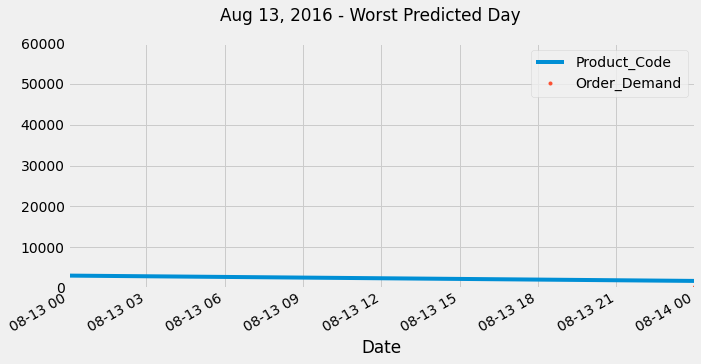

In [86]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_all[['Product_Code','Order_Demand']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

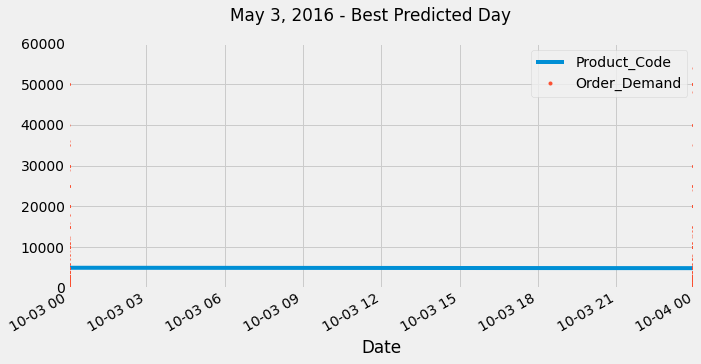

In [91]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_all[['Product_Code','Order_Demand']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('May 3, 2016 - Best Predicted Day')

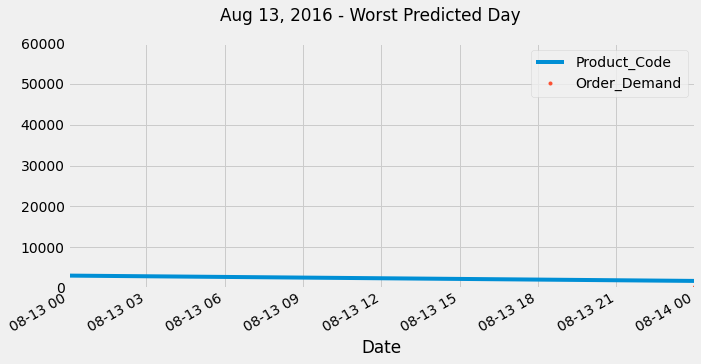

In [89]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_all[['Product_Code','Order_Demand']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')